## Paso 1: Instalar las dependencias y configurar el proyecto en GPU


In [1]:
!echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  14426      0 --:--:-- --:--:-- --:--:-- 14426
OK


In [10]:
!apt-get update & apt-get install tensorflow-model-server

Hit:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Reading package lists... Done
Building dependency tree       
Reading state information... Done
0% [11 

In [3]:
!pip install tensorflow-gpu==1.13.1

     |████████████████████████████████| 345.2MB 50kB/s 
     |████████████████████████████████| 3.2MB 29.8MB/s 
     |████████████████████████████████| 368kB 41.8MB/s 
ERROR: tensorflow 1.14.0 has requirement tensorboard<1.15.0,>=1.14.0, but you'll have tensorboard 1.13.1 which is incompatible.
ERROR: tensorflow 1.14.0 has requirement tensorflow-estimator<1.15.0rc0,>=1.14.0rc0, but you'll have tensorflow-estimator 1.13.0 which is incompatible.
  Found existing installation: tensorboard 1.14.0
    Uninstalling tensorboard-1.14.0:
      Successfully uninstalled tensorboard-1.14.0
  Found existing installation: tensorflow-estimator 1.14.0
    Uninstalling tensorflow-estimator-1.14.0:
      Successfully uninstalled tensorflow-estimator-1.14.0


In [4]:
!pip install requests

## Paso 2: Importar las dependencias del proyecto

In [1]:
import os
import json
import random
import requests
import subprocess
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import cifar10

%matplotlib inline
tf.__version__

'1.13.1'

## Paso 3: Pre procesado de los datos

### Cargar el dataset

In [0]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [0]:
class_names = ['avión', 'coche', 'pájaro', 'gato', 'ciervo', 'perro', 'rana', 'caballo', 'barco', 'camión']

### Normalización de imágenes

In [0]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [18]:
X_train.shape

(50000, 32, 32, 3)

## Paso 4: Definir el modelo

NOTA: Vamos a usar el mismo modelo que creamos en la Sección de Redes Neuronales Convolucionales

In [0]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[32, 32, 3]))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dense(units=10, activation='softmax'))

### Compilar el modelo

In [0]:
model.compile(optimizer='Adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['sparse_categorical_accuracy'])

###  Entrenar el modelo

In [21]:
model.fit(X_train, 
          y_train, 
          batch_size=128, 
          epochs=10)

Epoch 1/10
50000/50000 [==============================] - 12s 234us/sample - loss: 1.4912 - sparse_categorical_accuracy: 0.4612
Epoch 2/10
50000/50000 [==============================] - 11s 223us/sample - loss: 1.0638 - sparse_categorical_accuracy: 0.6223
Epoch 3/10
50000/50000 [==============================] - 11s 225us/sample - loss: 0.8560 - sparse_categorical_accuracy: 0.7009
Epoch 4/10
50000/50000 [==============================] - 11s 223us/sample - loss: 0.7215 - sparse_categorical_accuracy: 0.7493
Epoch 5/10
50000/50000 [==============================] - 11s 224us/sample - loss: 0.6046 - sparse_categorical_accuracy: 0.7885
Epoch 6/10
50000/50000 [==============================] - 11s 222us/sample - loss: 0.5052 - sparse_categorical_accuracy: 0.8221
Epoch 7/10
50000/50000 [==============================] - 11s 225us/sample - loss: 0.4166 - sparse_categorical_accuracy: 0.8538
Epoch 8/10
50000/50000 [==============================] - 11s 224us/sample - loss: 0.3382 - sparse_categ

### Evaluar el modelo

In [22]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

10000/10000 [==============================] - 2s 168us/sample - loss: 1.0588 - sparse_categorical_accuracy: 0.7350


In [24]:
print("La precisión del modelo es de {} %".format(test_accuracy*100.0))

La precisión del modelo es de 73.50000143051147 %


## Paso 5: Guardar el modelo para subir a producción

### Crear un directorio para el modelo

In [0]:
MODEL_DIR = "model/"
version = 1

In [26]:
export_path = os.path.join(MODEL_DIR, str(version))
export_path

'model/1'

In [0]:
if os.path.isdir(export_path):
    !rm -r {export_path}

### Guardar el modelo para TensorFlow Serving

In [39]:
tf.saved_model.simple_save(tf.keras.backend.get_session(), export_dir=export_path, inputs={"input_image":model.input}, outputs={t.name:t for t in model.outputs})

INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: model/1/saved_model.pb


## Paso 6: Configurar el entorno de producción

### Exportar el MODEL_DIR a las variables de entorno

In [0]:
os.environ['MODEL_DIR'] = os.path.abspath(MODEL_DIR)

### Ejecutar la API REST de TensorFlow Serving

In [11]:
%%bash --bg
nohup tensorflow_model_server --rest_api_port=8000 --model_name=cifar10 --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 3 in a separate thread.


In [12]:
!tail server.log

2019-08-07 10:08:17.405940: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:31] Reading SavedModel from: /content/model/1
2019-08-07 10:08:17.416011: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:54] Reading meta graph with tags { serve }
2019-08-07 10:08:17.427341: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-08-07 10:08:17.471008: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:202] Restoring SavedModel bundle.
2019-08-07 10:08:17.580525: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:311] SavedModel load for tags { serve }; Status: success. Took 174570 microseconds.
2019-08-07 10:08:17.580607: I tensorflow_serving/servables/tensorflow/saved_model_warmup.cc:103] No warmup data file found at /content/model/1/assets.extra/tf_serving_warmup_requests
2019-08-07 10:08:17.580706: I tensorflow_serving/cor

## Paso 7: Crear nuestra primera petición por POST

In [23]:
random_image = np.random.randint(0, len(X_test))
random_image

2656

### Crear el objeto de datos en JSON

In [0]:
data = json.dumps({"signature_name":"serving_default", "instances":[X_test[random_image].tolist()]})

In [15]:
data

'{"signature_name": "serving_default", "instances": [[[[0.10980392156862745, 0.16862745098039217, 0.20784313725490197], [0.12156862745098039, 0.17254901960784313, 0.20392156862745098], [0.12549019607843137, 0.19215686274509805, 0.23529411764705882], [0.12941176470588237, 0.20784313725490197, 0.2627450980392157], [0.09411764705882353, 0.1450980392156863, 0.17254901960784313], [0.058823529411764705, 0.06274509803921569, 0.058823529411764705], [0.0784313725490196, 0.10588235294117647, 0.10196078431372549], [0.10588235294117647, 0.1450980392156863, 0.14901960784313725], [0.10588235294117647, 0.13725490196078433, 0.1411764705882353], [0.09019607843137255, 0.10980392156862745, 0.11372549019607843], [0.11372549019607843, 0.12156862745098039, 0.11372549019607843], [0.07450980392156863, 0.08627450980392157, 0.09019607843137255], [0.12549019607843137, 0.1450980392156863, 0.1411764705882353], [0.1607843137254902, 0.1843137254901961, 0.16470588235294117], [0.1450980392156863, 0.17254901960784313, 

### Enviar la primera petición POST al modelo

In [0]:
headers = {"content-type":"application/json"}

In [0]:
json_response = requests.post(url="http://localhost:8000/v1/models/cifar10:predict", data=data, headers=headers)

In [26]:
json_response

<Response [200]>

In [0]:
predictions = json.loads(json_response.text)['predictions']

In [28]:
predictions

[[1.26298616e-09,
  3.42567225e-11,
  2.43073339e-10,
  2.89047062e-08,
  4.87489042e-12,
  4.10505553e-11,
  3.08533615e-11,
  7.64918184e-07,
  1.75791507e-14,
  0.999999166]]

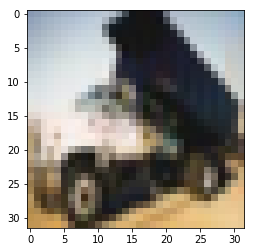

In [29]:
plt.imshow(X_test[random_image])

In [30]:
class_names[np.argmax(predictions[0])]

'camión'

## Paso 8: Enviar una petición POST a un modelo específico 

In [0]:
specific_json_response = requests.post(url="http://localhost:8000/v1/models/cifar10/versions/1:predict", data=data, headers=headers)

In [32]:
specific_json_response

<Response [200]>